# Exploratory Data Analysis Notebook
This notebook is dedicated to the exploratory data analysis of the large and focused final data sets. General facts about the data will be recorded and available in the following cells. Should it be warranted, they may also appear in the README file. We'll be using Pandas and Numpy for data processing and analysis and `matplotlib` and `seaborn` for data visualization. The first step is to load in the libraries and the data we're interested in. This data has already been cleaned up, but it still contains null values in some attributes that will have to handled during certain operations.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plot
import seaborn as sbn

# Import utility functions
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from utils import *
from classes import Plotter

df = pd.read_parquet(path='../data/processed/composite/dataset_focused.parquet')

The first thing to look at are general facts about the data we're interested in.

In [ ]:
# Experiment with EPSS score and percentile imputation here

# COL_TYPES = {
#     'string': ['cve_id'],
#     'date': ['epss_date_0', 'epss_date_30', 'epss_date_60'],
#     'float': [
#         'epss_0', 'epss_30', 'epss_60',
#         'percentile_0', 'percentile_30', 'percentile_60',
#         'change_0_to_30', 'change_30_to_60', 'change_total'
#     ]
# }

# # Strip whitespace
# epss = strip_whitespace_from(epss)
# print('Stripped the whitespace!\n')

# # Validate CVE ID
# epss['cve_id'] = epss['cve_id'].apply(validate_cve_id)
# print('Validated CVE ID format!\n')

# # Ensure floats are handled correctly by imputation
# for col in epss.columns:
#     if col != 'cve_id' and not pd.api.types.is_datetime64_any_dtype(epss[col]):
#         epss[col] = pd.to_numeric(epss[col])

# # Impute EPSS scores by averaging or extrapolation
# # df = impute_epss(df)
# # print('EPSS scores imputed!\n')

# # # Calculate change rates
# # def percent_change_between_cols(col1: pd.Series, col2: pd.Series) -> pd.Series:
# #     return ((col2 - col1) / col1.replace(0, pd.NA)) * 100
# # epss['change_0_to_30'] = percent_change_between_cols(epss['epss_0'], epss['epss_30'])
# # epss['change_30_to_60'] = percent_change_between_cols(epss['epss_30'], epss['epss_60'])
# # epss['change_total'] = percent_change_between_cols(epss['epss_0'], epss['epss_60'])
# # print('Calculated change rates!\n')

# # # Standardize nulls
# # epss = standardize_nulls(df)
# # print('Loaded the EPSS data!\n')

# # # Drop duplicates
# # epss = safely_drop_duplicates(df)
# # print('Dropped duplicates!\n')

# # # Define datatypes
# # epss = convert_cols(df, COL_TYPES)
# # print('Converted datatypes!\n')

# # # Drop duplicate date column
# # epss.drop(columns=['epss_date'], inplace=True)
# # print('Dropped duplicate date column!\n')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10891 entries, 0 to 10890
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   cve_id                10891 non-null  string             
 1   date_public           10678 non-null  datetime64[ns, UTC]
 2   origin                10891 non-null  category           
 3   cvss                  10290 non-null  Float64            
 4   cvss_severity         10891 non-null  category           
 5   cvss_src              10290 non-null  category           
 6   exploit_count         10891 non-null  Float64            
 7   days_to_poc_exploit   10678 non-null  Float64            
 8   exploitation_date_0   10891 non-null  datetime64[ns, UTC]
 9   epss_0                2886 non-null   Float64            
 10  percentile_0          2886 non-null   Float64            
 11  exploitation_date_30  10891 non-null  datetime64[ns, UTC]
 12  epss

There are no CVEs who have EPSS scores but do not have their corresponding percentiles, which is to be expected.

In [4]:
df[df['epss_0'].notnull() & df['percentile_0'].isnull()]

,cve_id,date_public,origin,cvss,cvss_severity,cvss_src,exploit_count,days_to_poc_exploit,exploitation_date_0,epss_0,percentile_0,exploitation_date_30,epss_30,percentile_30,exploitation_date_60,epss_60,percentile_60,change_0_to_30,change_30_to_60,change_0_60


The following diagram shows the amount of missing data in the dataset, represented by the color yellow. 

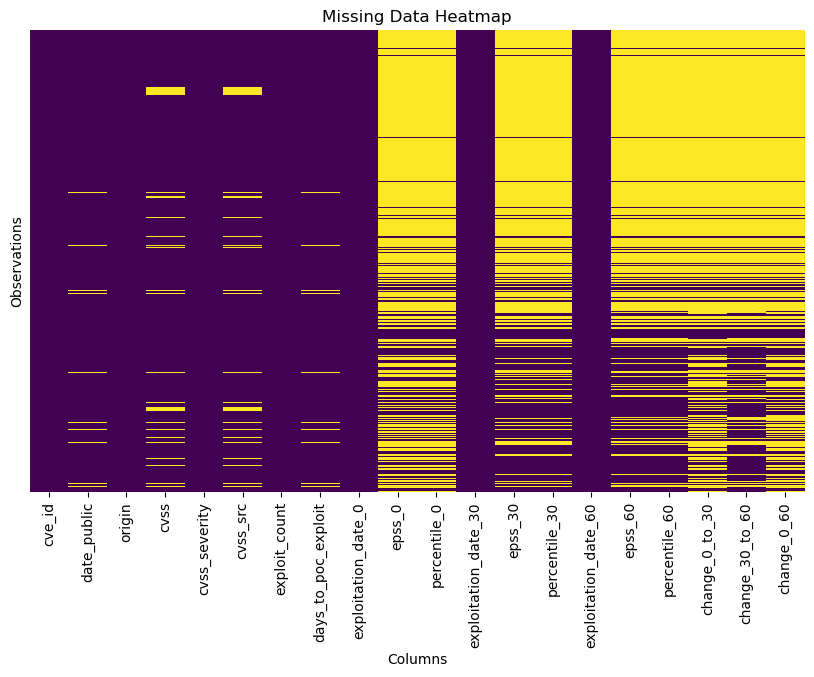

In [2]:
missing_values = df.isnull().sum()

# Plot missing data heatmap
plot.figure(figsize=(10, 6))
sbn.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plot.title("Missing Data Heatmap")
plot.xlabel("Columns")
plot.ylabel("Observations")
plot.show()

In [7]:
print(f'There are \033[32;1m{df.shape[0]}\033[0m CVE records in the data frame, each with \033[32;1m{df.shape[1]}\033[0m attributes.')
print('Some general statistics about the numerical columns:')

# Change output display for clarity
pd.options.display.precision = 3
df.describe().T

There are 10891 CVE records in the data frame, each with 20 attributes.
Some general statistics about the numerical columns:


,count,mean,std,min,25%,50%,75%,max
cvss,10290.0,7.36,1.794,0.0,6.1,7.5,8.8,10.0
exploit_count,10891.0,1.86,5.999,1.0,1.0,1.0,1.0,394.0
days_to_poc_exploit,10678.0,230.404,790.141,-4457.0,0.0,1.0,66.0,9978.0
epss_0,2886.0,0.072,0.194,0.0,0.001,0.007,0.023,0.976
percentile_0,2886.0,0.488,0.317,0.008,0.194,0.42,0.788,1.0
epss_30,3965.0,0.099,0.224,0.0,0.001,0.009,0.05,0.975
percentile_30,3965.0,0.554,0.334,0.008,0.229,0.563,0.895,1.0
epss_60,4008.0,0.104,0.233,0.0,0.001,0.009,0.055,0.975
percentile_60,4008.0,0.557,0.334,0.008,0.243,0.565,0.898,1.0
change_0_to_30,2824.0,2647.929,17799.523,-97.069,0.0,0.0,107.846,226241.86


There are $601$ CVEs with `UNKNOWN` CVSS score severities, calculated by virtue of their corresponding scores not belonging to the range of applicable numbers as set forth by FIRST.

In [8]:
df[(df['cvss'].isnull()) & (df['cvss_severity'].notnull())]['cvss_severity'].value_counts()

cvss_severity
UNKNOWN     601
CRITICAL      0
HIGH          0
LOW           0
MEDIUM        0
NONE          0
Name: count, dtype: int64

The following table shows summary statistics for the dataset's date variables.

In [9]:
date_cols = df.select_dtypes('datetime64[ns, UTC]').columns
df[date_cols].describe().T

,count,mean,min,25%,50%,75%,max
date_public,10678,2016-01-07 08:06:07.169118464+00:00,1990-08-14 04:00:00+00:00,2008-12-01 00:00:00+00:00,2018-04-19 12:00:00+00:00,2022-05-24 23:53:15+00:00,2025-01-28 22:15:15.860000+00:00
exploitation_date_0,10891,2016-10-06 01:45:41.016527616+00:00,1990-05-19 00:00:00+00:00,2009-04-20 00:00:00+00:00,2019-10-15 06:26:08+00:00,2023-01-31 22:51:30+00:00,2025-01-13 10:07:25+00:00
exploitation_date_30,10891,2016-11-05 01:45:41.016527360+00:00,1990-06-18 00:00:00+00:00,2009-05-20 00:00:00+00:00,2019-11-14 06:26:08+00:00,2023-03-02 22:51:30+00:00,2025-02-12 10:07:25+00:00
exploitation_date_60,10891,2016-12-05 01:45:41.016527360+00:00,1990-07-18 00:00:00+00:00,2009-06-19 00:00:00+00:00,2019-12-14 06:26:08+00:00,2023-04-01 22:51:30+00:00,2025-03-14 10:07:25+00:00


In [63]:
cvss_greater_than_or_equal_to_7 = df[df['cvss'] >= 7.0]
cvss_greater_than_or_equal_to_7_count = len(cvss_greater_than_or_equal_to_7)
nonnull_epss_0 = cvss_greater_than_or_equal_to_7[cvss_greater_than_or_equal_to_7['epss_0'].notnull()]
nonnull_epss_30 = cvss_greater_than_or_equal_to_7[cvss_greater_than_or_equal_to_7['epss_30'].notnull()]
nonnull_epss_60 = cvss_greater_than_or_equal_to_7[cvss_greater_than_or_equal_to_7['epss_60'].notnull()]
valid_epss_0_threshold = nonnull_epss_0[nonnull_epss_0['epss_0'] >= 0.5]
valid_epss_30_threshold = nonnull_epss_30[nonnull_epss_30['epss_30'] >= 0.5]
valid_epss_60_threshold = nonnull_epss_60[nonnull_epss_60['epss_60'] >= 0.5]

print(f"There are \033[32;1m{cvss_greater_than_or_equal_to_7_count}\033[0m CVEs with a CVSS score greater than or equal to 7.0.")
print(f"This is \033[32;1m{(cvss_greater_than_or_equal_to_7_count / df['cvss'].count()) * 100:.2f}%\033[0m of the total number of CVSS scores.")
print(f'These CVEs are henceforth refered to at "valid".')
print(f"Of valid CVEs, \033[32;1m{len(nonnull_epss_0)}\033[0m have non-null EPSS scores at day 0.")
print(f"\033[32;1m{len(valid_epss_0_threshold)}\033[0m of the CVEs have EPSS scores that fall above a threshold of 0.5.")
print(f"This is \033[32;1m{(len(valid_epss_0_threshold) / len(nonnull_epss_0)) * 100:.2f}%\033[0m of EPSS scores among valid CVEs.")
print(f"It's also \033[32;1m{(len(valid_epss_0_threshold) / df['epss_0'].count()) * 100:.2f}%\033[0m of the total number of EPSS scores.")
print(f"Day 30 scores number in at \033[32;1m{len(nonnull_epss_30)}\033[0m, \033[32;1m{(len(valid_epss_30_threshold) / len(nonnull_epss_30)) * 100:.2f}%\033[0m of valid CVEs and \033[32;1m{(len(valid_epss_30_threshold) / df['epss_30'].count()) * 100:.2f}%\033[0m of total CVEs.")
print(f"Day 60 scores number in at \033[32;1m{len(nonnull_epss_60)}\033[0m, \033[32;1m{(len(valid_epss_60_threshold) / len(nonnull_epss_60)) * 100:.2f}%\033[0m of valid CVEs  and \033[32;1m{(len(valid_epss_60_threshold) / df['epss_60'].count()) * 100:.2f}%\033[0m of total CVEs.")

There are 6706 CVEs with a CVSS score greater than or equal to 7.0.
This is 65.17% of the total number of CVSS scores.
These CVEs are henceforth refered to at "valid".
Of valid CVEs, 2169 have non-null EPSS scores at day 0.
134 of the CVEs have EPSS scores that fall above a threshold of 0.5.
This is 6.18% of EPSS scores among valid CVEs.
It's also 4.64% of the total number of EPSS scores.
Day 30 scores number in at 2824, 9.53% of valid CVEs and 6.78% of total CVEs.
Day 60 scores number in at 2822, 10.35% of valid CVEs  and 7.29% of total CVEs.


In [53]:
# Average number of days
avg_num_of_days = df['days_to_poc_exploit'].mean()
remainder_hrs = (avg_num_of_days % 1) * 24
remainder_mins = (remainder_hrs % 1) * 60
remainder_secs = (remainder_mins % 1) * 60

print(f"Average number of days from CVE publication to publication of first exploit code: \033[32;1m{avg_num_of_days:.0f} days {remainder_hrs:.0f} hours {remainder_mins:.0f} minutes {remainder_secs:.0f} seconds\033[0m.")

# Number and percentages
more_than_0_day_cves = df['days_to_poc_exploit'] >= 0
less_than_90_day_cves = df['days_to_poc_exploit'] <= 90
less_than_90_day_df = df[less_than_90_day_cves]
zero_to_90_day_cves = more_than_0_day_cves & less_than_90_day_cves
zero_to_90_day_df = df[zero_to_90_day_cves]

higher_criticality_cves = df['cvss'] >= 7.0
higher_criticality_and_less_than_90_day_df = df[less_than_90_day_cves & higher_criticality_cves]
higher_criticality_and_0_to_90_day_df = df[zero_to_90_day_cves & higher_criticality_cves]

print(f"There are \033[32;1m{len(less_than_90_day_df)}\033[0m (\033[32;1m{len(less_than_90_day_df) / len(df) * 100:.2f}%\033[0m of total CVEs) CVEs whose exploit codes were published sooner than 90 days.")
print(f"There are \033[32;1m{len(higher_criticality_and_less_than_90_day_df)}\033[0m (\033[32;1m{len(higher_criticality_and_less_than_90_day_df) / len(less_than_90_day_df) * 100:.2f}%\033[0m of the aforementioned CVEs) that have CVSS scores >= 7.")
print(f"There are \033[32;1m{len(zero_to_90_day_df)}\033[0m (\033[32;1m{len(zero_to_90_day_df) / len(df) * 100:.2f}%\033[0m of total CVES) CVEs whose exploit codes were published within the first 90 days.")
print(f"There are \033[32;1m{len(higher_criticality_and_0_to_90_day_df)}\033[0m (\033[32;1m{len(higher_criticality_and_0_to_90_day_df) / len(less_than_90_day_df) * 100:.2f}%\033[0m of the aforementioned CVEs) that have CVSS scores >= 7.")

Average number of days from CVE publication to publication of first exploit code: 230 days 10 hours 42 minutes 2 seconds.
There are 8228 (75.55% of total CVEs) CVEs whose exploit codes were published sooner than 90 days.
There are 4926 (59.87% of the aforementioned CVEs) that have CVSS scores >= 7.
There are 5827 (53.50% of total CVES) CVEs whose exploit codes were published within the first 90 days.
There are 3564 (43.32% of the aforementioned CVEs) that have CVSS scores >= 7.


## Verifying Distributive Normalcy
### Histogram, Q-Q Plots, and Scatterplots
From the looks of the histogram and Q-Q plots, none of the project's variables appear to be normally distributed; rather, they seem heavily skewed to the right, exponential, and perhaps bimodal. We can't rely on appearances alone though, so in the next section, we'll use several statistical tests to verify the data's shape mathematically.

Based on the results of these tests, we can perform correlation analysis with the Spearman's Rank Coefficient and Kendall's Tau and begin to flesh out an analysis that will help validate the effectiveness of the project's model versus the CVSS and EPSS parameters. Scatterplots graphing the relationship between variables will help in this endeavour to visualize any relationships that may emerge.

In [11]:
df['cvss_severity'].value_counts()

cvss_severity
HIGH        4501
MEDIUM      3394
CRITICAL    2205
UNKNOWN      601
LOW          186
NONE           4
Name: count, dtype: int64

Transformation type unknown: None
No transformation applied to cvss.
Plot saved: ../plots\frequency_of_cves_with_varying_cvss_scores.png


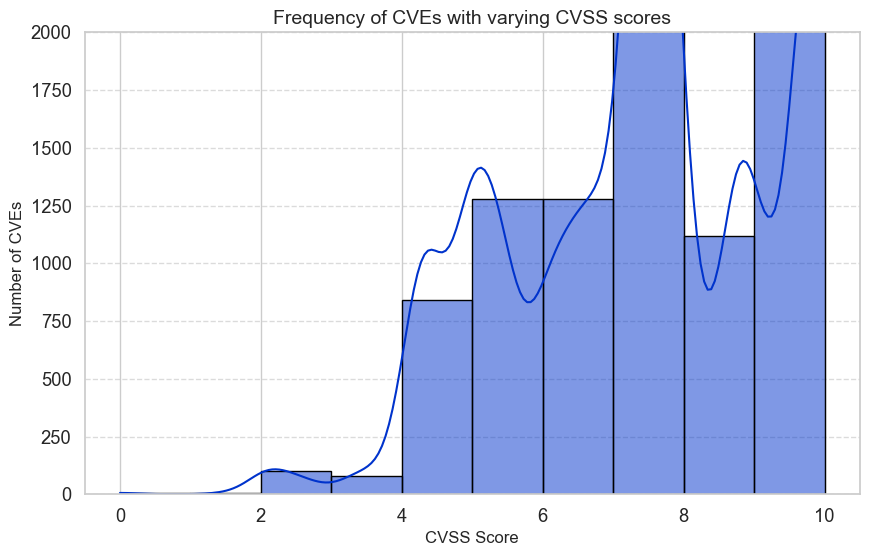

Transformation type unknown: None
No transformation applied to cvss_severity.
Plot saved: ../plots\frequency_of_cvss_severity_levels.png


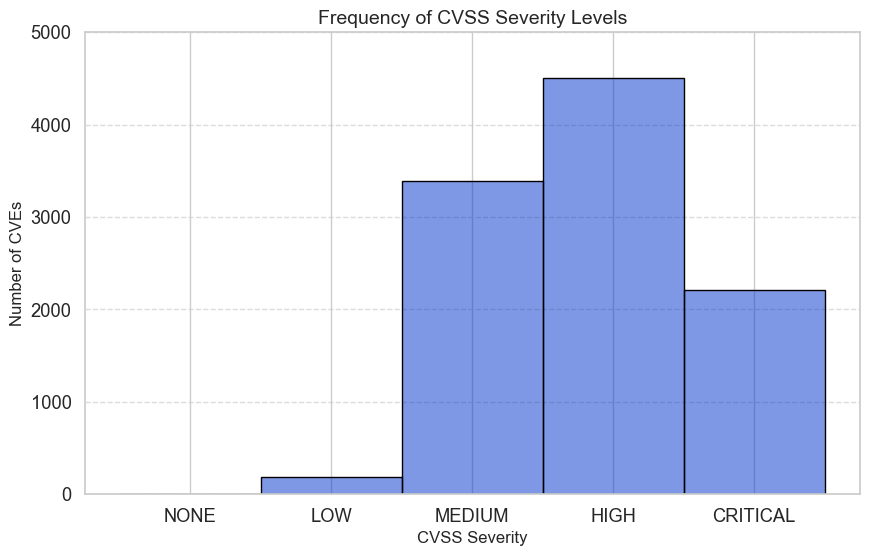

Plot saved: ../plots\distribution_of_exploit_counts.png


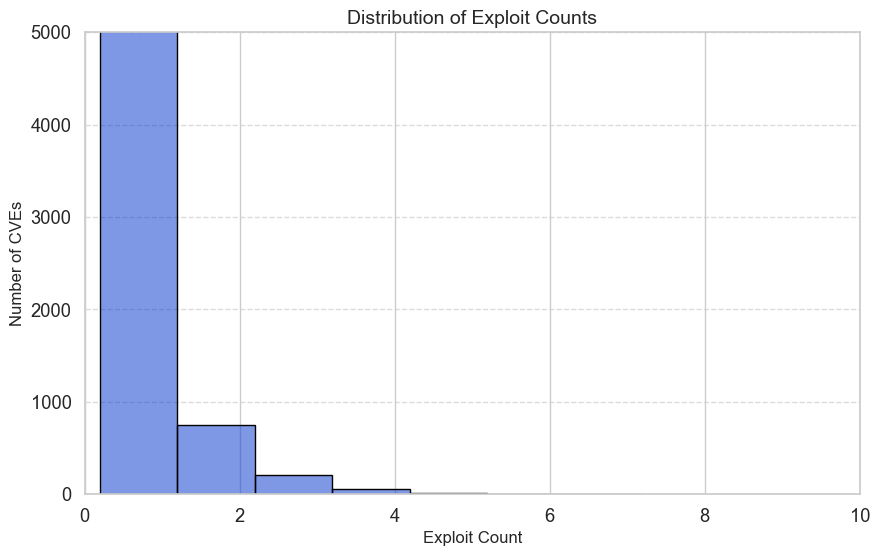

Transformation type unknown: None
No transformation applied to days_to_poc_exploit.
Plot saved: ../plots\time_to_first_exploit_code_publishing.png


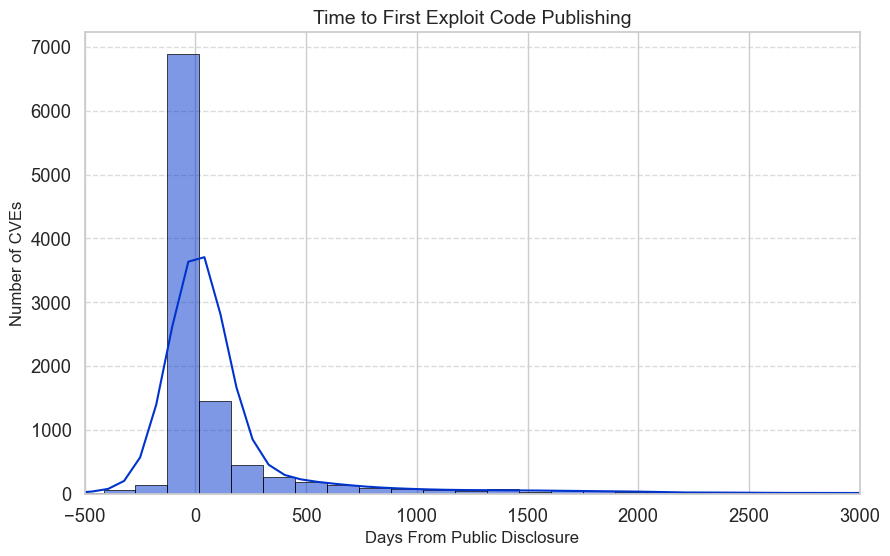

Transformation type unknown: None
No transformation applied to epss_0.
Plot saved: ../plots\epss_scores_on_exploit_code_publish_date.png


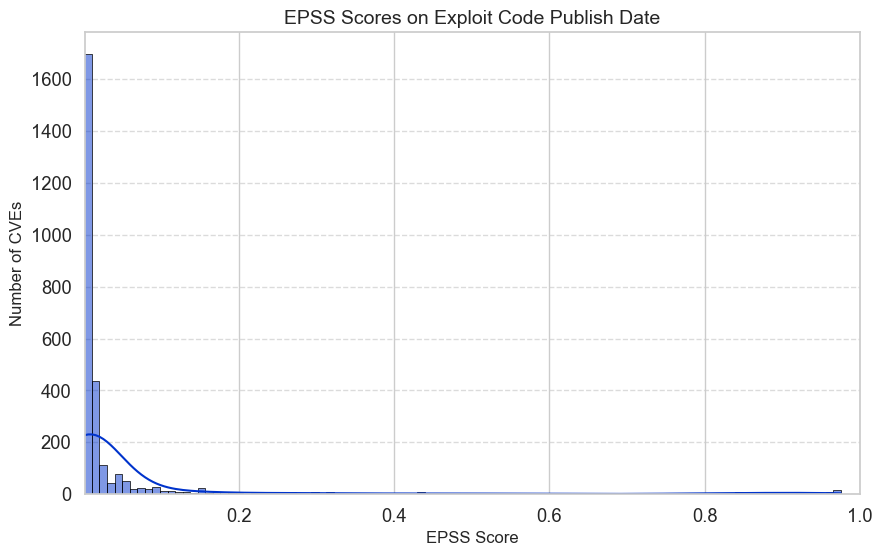

Transformation type unknown: None
No transformation applied to epss_30.
Plot saved: ../plots\epss_scores_30_days_after_exploit_code_publish_date.png


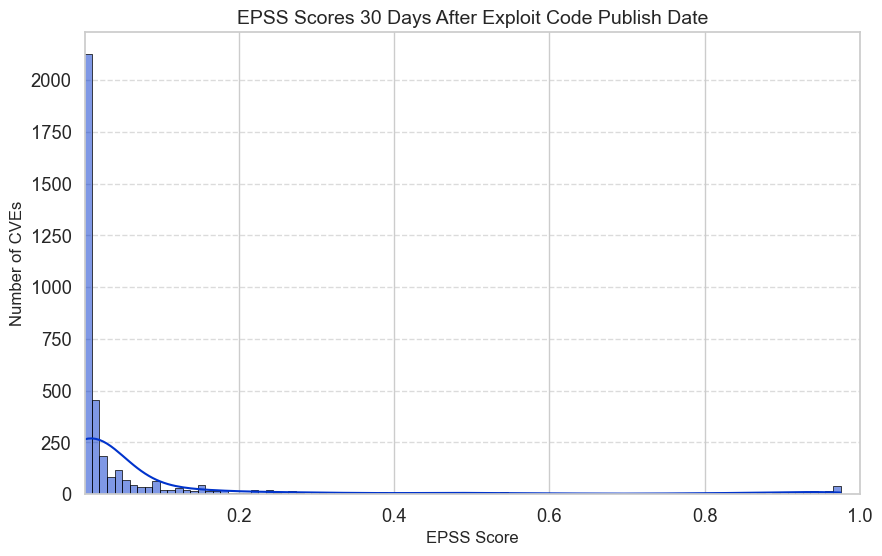

Transformation type unknown: None
No transformation applied to epss_60.
Plot saved: ../plots\epss_scores_60_days_after_exploit_code_publish_date.png


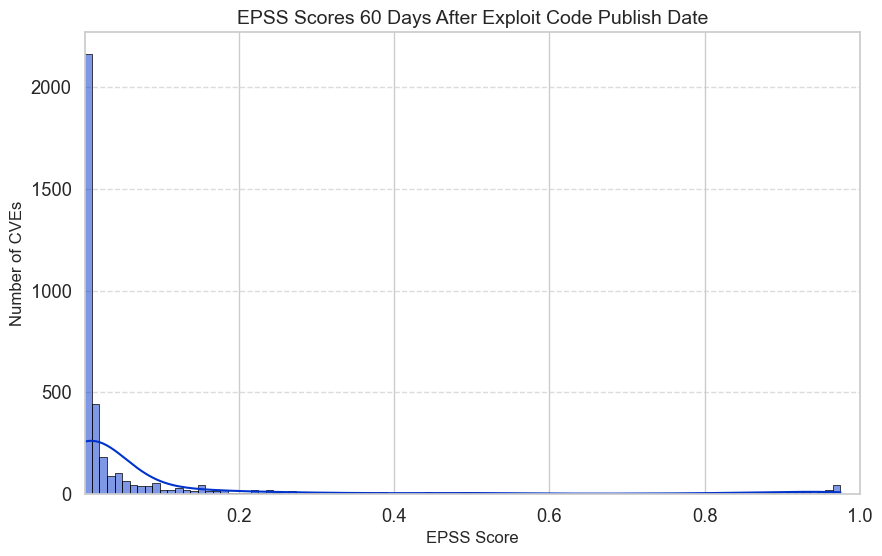

In [4]:
# Load Plotter
plotter = Plotter(figsize=(10, 6), save_fig=True)

# Plot histograms
plotter.plot_histogram(
    df,
    column='cvss',
    title='Frequency of CVEs with varying CVSS scores',
    xlabel='CVSS Score',
    ylabel='Number of CVEs',
    bins=np.arange(0, df['cvss'].max() + 1, 1),
    alpha=0.5,
    ylim=(0, 2000)
)

# Define xlabels for severity
xlabels = ['NONE', 'LOW', 'MEDIUM', 'HIGH', 'CRITICAL']

# Alphabetically reorder severity categories
df['cvss_severity'] = pd.Categorical(df['cvss_severity'], categories=xlabels, ordered=True)

plotter.plot_histogram(
    df=df[df['cvss_severity'] != 'UNKNOWN'],
    column='cvss_severity',
    title='Frequency of CVSS Severity Levels',
    xlabel='CVSS Severity',
    ylabel='Number of CVEs',
    bins=10,
    alpha=0.5,
    ylim=(0, 5000),
    discrete=True,
    kde=False,
    xlabels=xlabels
)
plotter.plot_histogram(
    df,
    column='exploit_count',
    title='Distribution of Exploit Counts',
    xlabel='Exploit Count',
    ylabel='Number of CVEs',
    bins=np.arange(0, df['exploit_count'].max() + 1, 1) - 0.5,
    alpha=0.5,
    xlim=(0, 10),
    ylim=(0, 5000),
    transform='log',
    discrete=True,
    kde=False
)
plotter.plot_histogram(
    df,
    column='days_to_poc_exploit',
    title='Time to First Exploit Code Publishing',
    xlabel='Days From Public Disclosure',
    ylabel='Number of CVEs',
    bins=100,
    alpha=0.5,
    xlim=(-500, 3000)
)
plotter.plot_histogram(
    df,
    column='epss_0',
    title='EPSS Scores on Exploit Code Publish Date',
    xlabel='EPSS Score',
    ylabel='Number of CVEs',
    bins=100,
    alpha=0.5,
    xlim=(0.001, 1.000),
    # ylim=(0, 200)
)
plotter.plot_histogram(
    df,
    column='epss_30',
    title='EPSS Scores 30 Days After Exploit Code Publish Date',
    xlabel='EPSS Score',
    ylabel='Number of CVEs',
    bins=100,
    alpha=0.5,
    xlim=(0.001, 1.000),
    # ylim=(0, 200)
)
plotter.plot_histogram(
    df,
    column='epss_60',
    title='EPSS Scores 60 Days After Exploit Code Publish Date',
    xlabel='EPSS Score',
    ylabel='Number of CVEs',
    bins=100,
    alpha=0.5,
    xlim=(0.001, 1.000),
    # ylim=(0, 200)
)

Transformation type unknown: None
No transformation applied to cvss.
Plot saved: ../plots\norm_qq_plot_of_cvss_scores.png


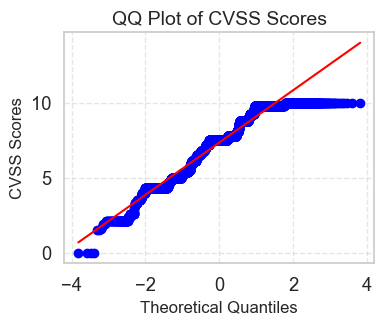

Transformation type unknown: None
No transformation applied to exploit_count.
Plot saved: ../plots\norm_qq_plot_of_exploit_count.png


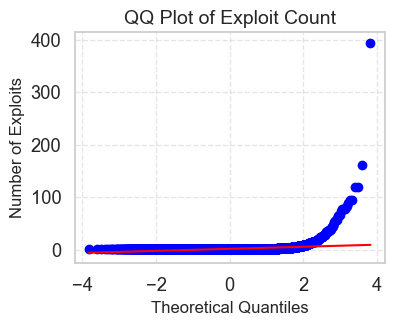

Transformation type unknown: None
No transformation applied to days_to_poc_exploit.
Plot saved: ../plots\norm_qq_plot_of_the_interval_between_cve_disclosure_and_exploit_code_publish_date.png


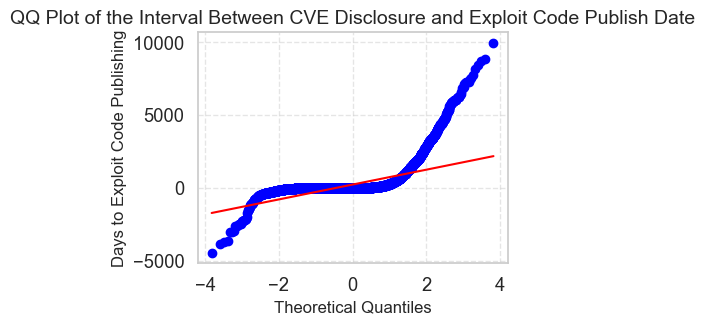

Transformation type unknown: None
No transformation applied to epss_0.
Plot saved: ../plots\norm_qq_plot_of_epss_scores_on_exploit_code_publish_date.png


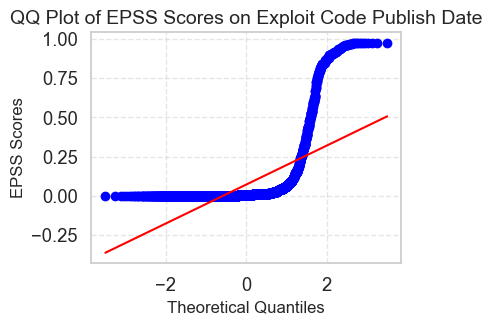

Transformation type unknown: None
No transformation applied to epss_30.
Plot saved: ../plots\norm_qq_plot_of_epss_scores_30_days_after_on_exploit_code_publish_date.png


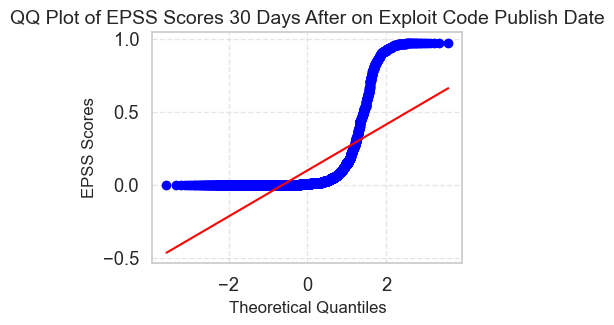

Transformation type unknown: None
No transformation applied to epss_60.
Plot saved: ../plots\norm_qq_plot_of_epss_scores_60_days_after_exploit_code_publish_date.png


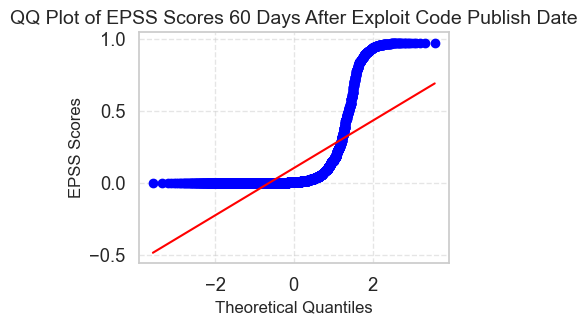

Transformation type unknown: None
No transformation applied to change_0_to_30.
Plot saved: ../plots\norm_qq_plot_of_change_rate_of_epss_scores_across_30_days_from_exploit_code_publish_date.png


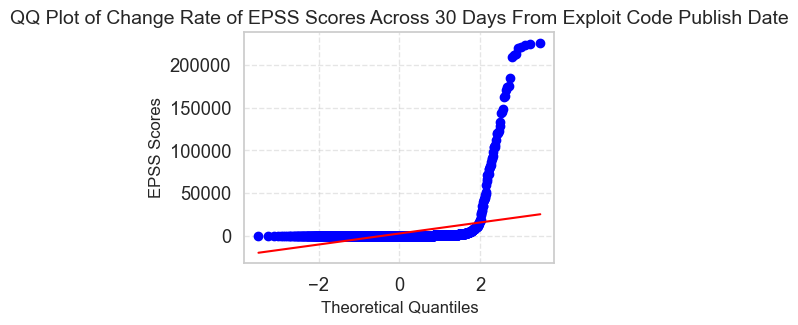

Transformation type unknown: None
No transformation applied to change_30_to_60.
Plot saved: ../plots\norm_qq_plot_of_change_rate_of_epss_scores_30_60_days_after_exploit_code_publish_date.png


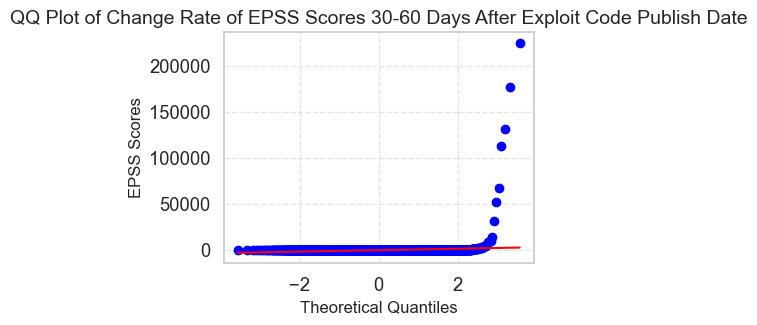

Transformation type unknown: None
No transformation applied to change_0_60.
Plot saved: ../plots\norm_qq_plot_of_change_rate_of_epss_scores_across_60_days_from_exploit_code_publish_date.png


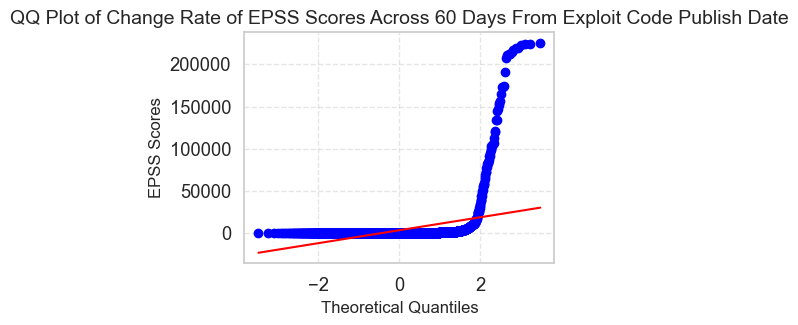

In [15]:
# Configure Q-Q plots
plotter.plot_qq(
    df,
    column='cvss',
    dist='norm',
    title='QQ Plot of CVSS Scores',
    xlabel='Theoretical Quantiles',
    ylabel='CVSS Scores',
    color='blue',
)
plotter.plot_qq(
    df,
    column='exploit_count',
    dist='norm',
    title='QQ Plot of Exploit Count',
    xlabel='Theoretical Quantiles',
    ylabel='Number of Exploits',
    color='blue'
)
plotter.plot_qq(
    df,
    column='days_to_poc_exploit',
    dist='norm',
    title='QQ Plot of the Interval Between CVE Disclosure and Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='Days to Exploit Code Publishing',
    color='blue',
)
plotter.plot_qq(
    df,
    column='epss_0',
    dist='norm',
    title='QQ Plot of EPSS Scores on Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    df,
    column='epss_30',
    dist='norm',
    title='QQ Plot of EPSS Scores 30 Days After on Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    df,
    column='epss_60',
    dist='norm',
    title='QQ Plot of EPSS Scores 60 Days After Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    df,
    column='change_0_to_30',
    dist='norm',
    title='QQ Plot of Change Rate of EPSS Scores Across 30 Days From Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    df,
    column='change_30_to_60',
    dist='norm',
    title='QQ Plot of Change Rate of EPSS Scores 30-60 Days After Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    df,
    column='change_0_60',
    dist='norm',
    title='QQ Plot of Change Rate of EPSS Scores Across 60 Days From Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)

### Statistical Normality Testing
We'll make use of two common statistical tests for normality: the **Anderson-Darling** and the **Kolmogorov-Smirnov**. Another common test is the **Shapiro-Wilk**, though it works best on much smaller sample sizes. All three of these tests assume *continuous*, univariate data. Very large sample sizes may be significantly impacted even by negligible deviations from normality, so the best approach is to take a random sample of the variables in question, the number of which will depend on the test in question.

<span style='color:#ffcc00;text-shadow:0 0 3px #ffcc00;'>! Bootstrap resampling the dataset for tests of normality will not provide any additional information because such resampling will produce exactly the same shape for every resample. Resampling is thus unnecessary during the normality testing phase of analysis.</span>

<span style='color:#33ff33;text-shadow:0 0 3px #33ff33;'>Each of these tests concludes for every variable of interest that we have to reject the null hypothesis that the data are normally-distributed.</span>

In [76]:
# Drop null values to enable correlation testing
valid_df = df[['cvss', 'epss_0', 'days_to_poc_exploit']].dropna()

# Variables to test
cvss = valid_df['cvss']
epss = valid_df['epss_0']
days_to_exploit = valid_df['days_to_poc_exploit']

# Sample the data
cvss_sample = cvss.sample(100, random_state=1945)
epss_sample = epss.sample(1000, random_state=1945)
days_to_exploit_sample = days_to_exploit.sample(1000, random_state=1945)

#### Anderson-Darling
The Anderson-Darling test is also used to measure the whether *continuous* data comes from a specified distribution (in this case, a normal one). The larger the test statistic ($A$), the further away from normality our data will be. Instead of a $p$ value, this $A$ statistic is returned with a set of critical values at various significance levels. If the $A$ statistic is larger than the critical value for a given significance level, we then reject the null hypothesis that the data are normally distributed. The test is more sensitive to deviations in the tails of skewed data.

In [85]:
# Anderson-Darling
cvss_stat = stats.anderson(cvss_sample, dist='norm')
epss_stat = stats.anderson(epss_sample, dist='norm')
days_to_exploit_stat = stats.anderson(days_to_exploit_sample, dist='norm')

print(f'Anderson-Darling test for CVSS: \033[32;1m{cvss_stat.statistic:.2f}\033[0m')
print(f'Critical values (5% / alpha level 0.05): \033[32;1m{cvss_stat.critical_values[2]:.2f}\033[0m')
if cvss_stat.statistic > cvss_stat.critical_values[2]:
    print('Because the test statistic is greater than the critical value at our desired alpha level, \033[32;1mwe must reject the null hypothesis.\033[0m\n')
else:
    print('The test statistic is less than the critical value at our desired alpha level, therefore \033[32;1mwe fail to reject the null hypothesis.\033[0m\n')

print(f'Anderson-Darling test for EPSS: \033[32;1m{cvss_stat.statistic:.2f}\033[0m')
print(f'Critical values (5% / alpha level 0.05): \033[32;1m{epss_stat.critical_values[2]:.2f}\033[0m')
if epss_stat.statistic > epss_stat.critical_values[2]:
    print('Because the test statistic is greater than the critical value at our desired alpha level, \033[32;1mwe must reject the null hypothesis.\033[0m\n')
else:
    print('The test statistic is less than the critical value at our desired alpha level, therefore \033[32;1mwe fail to reject the null hypothesis.\033[0m\n')

print(f'Anderson-Darling test for first exploit code publish date: \033[32;1m{days_to_exploit_stat.statistic:.2f}\033[0m')
print(f'Critical values (5% / alpha level 0.05): \033[32;1m{days_to_exploit_stat.critical_values[2]:.2f}\033[0m')
if days_to_exploit_stat.statistic > days_to_exploit_stat.critical_values[2]:
    print('Because the test statistic is greater than the critical value at our desired alpha level, \033[32;1mwe must reject the null hypothesis.\033[0m\n')
else:
    print('The test statistic is less than the critical value at our desired alpha level, therefore \033[32;1mwe fail to reject the null hypothesis.\033[0m\n')

Anderson-Darling test for CVSS: 2.61
Critical values (5% / alpha level 0.05): 0.76
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Anderson-Darling test for EPSS: 2.61
Critical values (5% / alpha level 0.05): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Anderson-Darling test for first exploit code publish date: 121.85
Critical values (5% / alpha level 0.05): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.



#### Kolmogorov-Smirnov
The Kolmogorov-Smirnov test compares the empirical distribution of the data to the theoretical distribution (often a normal distribution, but can be any *continuous* distribution). It provides a measure of the largest difference between the two distributions, given by a $D$ statistic, and a $p$ value that will indicate whether the null hypothesis will be rejected.

The way we can interpret the results of this test is fairly simple: the closer our test stat gets to $1$, the more different from our theoretical distribution the actual distribution is shown to be.

In [88]:
# Kolmogorov-Smirnov
# Kolmogorov-Smirnov
cvss_stat, cvss_p_value = stats.kstest(cvss, 'norm')
epss_stat, epss_p_value = stats.kstest(epss, 'norm')
days_to_exploit_stat, days_to_exploit_p_value = stats.kstest(days_to_exploit, 'norm')

print(f'Kolmogorov-Smirnov test for CVSS: \033[32;1m{cvss_stat:.2f}\033[0m | p-value: \033[32;1m{cvss_p_value:.2f}\033[0m')
print(f'Kolmogorov-Smirnov test for EPSS: \033[32;1m{epss_stat:.2f}\033[0m | p-value: \033[32;1m{epss_p_value:.2f}\033[0m')
print(f'Kolmogorov-Smirnov test for first exploit code publication date: \033[32;1m{days_to_exploit_stat:.2f}\033[0m | p-value: \033[32;1m{days_to_exploit_p_value:.2f}\033[0m')

Kolmogorov-Smirnov test for CVSS: 0.99 | p-value: 0.00
Kolmogorov-Smirnov test for EPSS: 0.50 | p-value: 0.00
Kolmogorov-Smirnov test for first exploit code publication date: 0.90 | p-value: 0.00


#### Shapiro-Wilk
The Shapiro-Wilk test tests the null hypothesis that a sample $x_1, ..., x_n$ came from a normally distributed population of *continuous* data. The closer the test statistic $W$ is to $1$, the closer the data is to a normal distribution, but if the $p$ value provided by the test falls below the chosen alpha level (e.g $0.05$), we must reject the null and conclude that the data is not sufficiently normal enough to do correlation testing with Pearson's rank coefficient. Since this test relies on smaller sample sizes, I've sampled $100$ observations instead of $1000$.

Based on the results of this particular test, all three of our variables statistically significantly deviate from a normal distribution.

In [90]:
# Shapiro-Wilk
cvss_stat, cvss_p_value = stats.shapiro(cvss_sample)
epss_stat, epss_p_value = stats.shapiro(epss_sample)
days_to_exploit_stat, days_to_exploit_p_value = stats.shapiro(days_to_exploit_sample)

print(f'Shapiro-Wilk Test for CVSS: \033[32;1m{cvss_stat:.2f}\033[0m | p-value: \033[32;1m{cvss_p_value:.2f}\033[0m')
print(f'Shapiro-Wilk Test for EPSS: \033[32;1m{epss_stat:.2f}\033[0m | p-value: \033[32;1m{epss_p_value:.2f}\033[0m')
print(f'Shapiro-Wilk Test for Days to First Patch: \033[32;1m{days_to_exploit_stat:.2f}\033[0m | p-value: \033[32;1m{days_to_exploit_p_value:.2f}\033[0m')

Shapiro-Wilk Test for CVSS: 0.93 | p-value: 0.00
Shapiro-Wilk Test for EPSS: 0.41 | p-value: 0.00
Shapiro-Wilk Test for Days to First Patch: 0.61 | p-value: 0.00


### Correlation Testing

Based on the following correlation tests, which used both Spearman's rank coefficient and Kendall's Tau, every relationship tested ranges from basically significant (as is the case between CVSS scores and days to exploit code publish date) to perfectly statistically significant (as is the case between EPSS scores and days to exploit code publish date).

We can interpret these coefficients and their $p$-values in the following table:
| Relationship | Spearman's ρ | Kendall's τ | $p$-value | Interpretation |
| --- | --- | --- | --- | --- |
| CVSS ⇆ EPSS | $0.15$ | $0.11$ | $0.00$ | Weak positive correlation with a very strong statistical significance |
| CVSS ⇆ Exploit Code Publish Date | $-0.04$ | $-0.03$ | $0.03$ | Very weak negative correlation with a meaningful statistical significance |
| EPSS ⇆ Exploit Code Publish Date | $0.47$ | $0.33$ | $0.00$ | Moderately positive correlation with a near-perfect statistical significance |

In [91]:

# § CVSS <-> EPSS
# Spearman's Correlation
spearman_corr, spearman_p = stats.spearmanr(cvss, epss)
# Kendall's Tau
kendall_corr, kendall_p = stats.kendalltau(cvss, epss)
print(f"Spearman's correlation between CVSS and EPSS: \033[32;1m{spearman_corr:.2f}\033[0m | p-value: \033[32;1m{spearman_p:.2f}\033[0m")
print(f"Kendall's Tau correlation between CVSS and EPSS: \033[32;1m{kendall_corr:.2f}\033[0m | p-value: \033[32;1m{kendall_p:.2f}\033[0m\n")

# § CVSS <-> Exploitation Date
# Spearman's Correlation
spearman_corr, spearman_p = stats.spearmanr(cvss, days_to_exploit)
# Kendall's Tau: Test the relationship between CVSS scores and the time to exploit
kendall_corr, kendall_p = stats.kendalltau(cvss, days_to_exploit)
print(f"Spearman's correlation between CVSS and first exploit code publication date: \033[32;1m{spearman_corr:.2f}\033[0m | p-value: \033[32;1m{spearman_p:.2f}\033[0m")
print(f"Kendall's Tau correlation between CVSS and first exploit code publication date: \033[32;1m{kendall_corr:.2f}\033[0m | p-value: \033[32;1m{kendall_p:.2f}\033[0m\n")

# § EPSS <-> Exploitation Date
# Spearman's Correlation
spearman_corr, spearman_p = stats.spearmanr(epss, days_to_exploit)
# Kendall's Tau: Test the relationship between CVSS scores and the time to exploit
kendall_corr, kendall_p = stats.kendalltau(epss, days_to_exploit)
print(f"Spearman's correlation between EPSS and first exploit code publication date: \033[32;1m{spearman_corr:.2f}\033[0m | p-value: \033[32;1m{spearman_p:.2f}\033[0m")
print(f"Kendall's Tau correlation between EPSS and first exploit code publication date: \033[32;1m{kendall_corr:.2f}\033[0m | p-value: \033[32;1m{kendall_p:.2f}\033[0m")

Spearman's correlation between CVSS and EPSS: 0.15 | p-value: 0.00
Kendall's Tau correlation between CVSS and EPSS: 0.11 | p-value: 0.00

Spearman's correlation between CVSS and first exploit code publication date: -0.04 | p-value: 0.03
Kendall's Tau correlation between CVSS and first exploit code publication date: -0.03 | p-value: 0.03

Spearman's correlation between EPSS and first exploit code publication date: 0.47 | p-value: 0.00
Kendall's Tau correlation between EPSS and first exploit code publication date: 0.33 | p-value: 0.00


Despite the above tests demonstrating perfectly-well the correlation between our focus variables, we can analyze the relationships further with bootstrap resampling, which let us determine the standard deviation of the correlation coefficients produced by these tests. This will help us determine how accurately they are determining the correlation.

In [ ]:
# Number of bootstrap iterations to perform
iterations = 10000

# Storage units for both correlation models' coefficients across iterations
spearman_corrs_cvss_epss = []
kendall_corrs_cvss_epss = []
spearman_corrs_cvss_days_to_exploit = []
kendall_corrs_cvss_days_to_exploit = []
spearman_corrs_epss_days_to_exploit = []
kendall_corrs_epss_days_to_exploit = []

# Initiliaze the current iteration across resamplings
spearman_iter_cvss_epss = 0
kendall_iter_cvss_epss = 0
spearman_iter_cvss_days_to_exploit = 0
kendall_iter_cvss_days_to_exploit = 0
spearman_iter_epss_days_to_exploit = 0
kendall_iter_epss_days_to_exploit = 0

# If we didn't already know (which we do), we'd drop any empty values here and
#   make sure that each variable of interest contain the same number of
#   observations

# Perform bootstrapping
for _ in range(iterations):
    sample_index = np.random.choice(
        len(valid_df), size=len(valid_df), replace=True
    ) # Grab as many observations as are in the original sample and create a new sampling with the same amount of observations

    # Grab the values in each column for the specified index
    cvss_sample = valid_df['cvss'].iloc[sample_index]
    epss_sample = valid_df['epss_0'].iloc[sample_index]
    days_to_exploit_sample = valid_df['days_to_poc_exploit'].iloc[sample_index]

    # Calculate Spearman and Kendall correlations and p-values
    spearman_corr_cvss_epss, spearman_p_cvss_epss = stats.spearmanr(cvss_sample, epss_sample)
    kendall_corr_cvss_epss, kendall_p_cvss_epss = stats.kendalltau(cvss_sample, epss_sample)

    spearman_corr_cvss_days_to_exploit, spearman_p_cvss_days_to_exploit = stats.spearmanr(
        cvss_sample, days_to_exploit_sample
    )
    kendall_corr_cvss_days_to_exploit, kendall_p_cvss_days_to_exploit = stats.kendalltau(
        cvss_sample, days_to_exploit_sample
    )

    spearman_corr_epss_days_to_exploit, spearman_p_epss_days_to_exploit = stats.spearmanr(
        epss_sample, days_to_exploit_sample
    )
    kendall_corr_epss_days_to_exploit, kendall_p_epss_days_to_exploit = stats.kendalltau(
        epss_sample, days_to_exploit_sample
    )

    # Append correlation coefficients to storage units
    spearman_corrs_cvss_epss.append(spearman_corr_cvss_epss)
    kendall_corrs_cvss_epss.append(kendall_corr_cvss_epss)

    spearman_corrs_cvss_days_to_exploit.append(
        spearman_corr_cvss_days_to_exploit
    )
    kendall_corrs_cvss_days_to_exploit.append(kendall_corr_cvss_days_to_exploit)

    spearman_corrs_epss_days_to_exploit.append(
        spearman_corr_epss_days_to_exploit
    )
    kendall_corrs_epss_days_to_exploit.append(kendall_corr_epss_days_to_exploit)

    # Count the frequency of p values that show statistical significance
    if spearman_p_cvss_epss < 0.05:
        spearman_iter_cvss_epss += 1
    if kendall_p_cvss_epss < 0.05:
        kendall_iter_cvss_epss += 1

    if spearman_p_cvss_days_to_exploit < 0.05:
        spearman_iter_cvss_days_to_exploit += 1
    if kendall_p_cvss_days_to_exploit < 0.05:
        kendall_iter_cvss_days_to_exploit += 1

    if spearman_p_epss_days_to_exploit < 0.05:
        spearman_iter_epss_days_to_exploit += 1
    if kendall_p_epss_days_to_exploit < 0.05:
        kendall_iter_epss_days_to_exploit += 1

# Calculate mean of correlation coefficients
mean_spearman_corrs_cvss_epss = np.mean(spearman_corrs_cvss_epss)
mean_kendall_corrs_cvss_epss = np.mean(kendall_corrs_cvss_epss)

mean_spearman_corrs_cvss_days_to_exploit = np.mean(
    spearman_corrs_cvss_days_to_exploit
)
mean_kendall_corrs_cvss_days_to_exploit = np.mean(
    kendall_corrs_cvss_days_to_exploit
)

mean_spearman_corrs_epss_days_to_exploit = np.mean(
    spearman_corrs_epss_days_to_exploit
)
mean_kendall_corrs_epss_days_to_exploit = np.mean(
    kendall_corrs_epss_days_to_exploit
)

# Calculate standard deviation of correlation coefficients
std_spearman_corrs_cvss_epss = np.std(spearman_corrs_cvss_epss)
std_kendall_corrs_cvss_epss = np.std(kendall_corrs_cvss_epss)

std_spearman_corrs_cvss_days_to_exploit = np.std(
    spearman_corrs_cvss_days_to_exploit
)
std_kendall_corrs_cvss_days_to_exploit = np.std(
    kendall_corrs_cvss_days_to_exploit
)

std_spearman_corrs_epss_days_to_exploit = np.std(
    spearman_corrs_epss_days_to_exploit
)
std_kendall_corrs_epss_days_to_exploit = np.std(
    kendall_corrs_epss_days_to_exploit
)


print(f"Spearman's correlation between CVSS and EPSS | MEAN: \033[32;1m{mean_spearman_corrs_cvss_epss:.2f}\033[0m | STANDARD DEVIATION: \033[32;1m{std_spearman_corrs_cvss_epss:.2f}\033[0m | % OF SIGNIFICANT SAMPLES: \033[32;1m{(spearman_iter_cvss_epss / iterations) * 100:.2f}\033[0m%\n")
print(f"Kendall's correlation between CVSS and EPSS | MEAN: \033[32;1m{mean_kendall_corrs_cvss_epss:.2f}\033[0m |STANDARD DEVIATION: \033[32;1m{std_kendall_corrs_cvss_epss:.2f}\033[0m | % OF SIGNIFICANT SAMPLES: \033[32;1m{(kendall_iter_cvss_epss / iterations) * 100:.2f}\033[0m%\n")

print(f"Spearman's correlation between CVSS and first exploit code publication date | MEAN: \033[32;1m{mean_spearman_corrs_cvss_days_to_exploit:.2f}\033[0m | STANDARD DEVIATION: \033[32;1m{std_spearman_corrs_cvss_days_to_exploit:.2f}\033[0m | % OF SIGNIFICANT SAMPLES: \033[32;1m{(spearman_iter_cvss_days_to_exploit / iterations) * 100:.2f}%\033[0m")
print(f"Kendall's correlation between CVSS and first exploit code publication date | MEAN: \033[32;1m{mean_kendall_corrs_cvss_days_to_exploit:.2f}\033[0m | STANDARD DEVIATION: \033[32;1m{std_kendall_corrs_cvss_days_to_exploit:.2f}\033[0m | % OF SIGNIFICANT SAMPLES: \033[32;1m{(kendall_iter_cvss_days_to_exploit / iterations) * 100:.2f}%\033[0m\n")

print(f"Spearman's correlation between EPSS and first exploit code publication date | MEAN: \033[32;1m{mean_spearman_corrs_epss_days_to_exploit:.2f}\033[0m | STANDARD DEVIATION: \033[32;1m{std_spearman_corrs_epss_days_to_exploit:.2f}\033[0m | % OF SIGNIFICANT SAMPLES: \033[32;1m{(spearman_iter_epss_days_to_exploit / iterations) * 100:.2f}%\033[0m")
print(f"Kendall's correlation between EPSS and first exploit code publication date | MEAN: \033[32;1m{mean_kendall_corrs_epss_days_to_exploit:.2f}\033[0m | STANDARD DEVIATION: \033[32;1m{std_kendall_corrs_epss_days_to_exploit:.2f}\033[0m | % OF SIGNIFICANT SAMPLES: \033[32;1m{(kendall_iter_epss_days_to_exploit / iterations) * 100:.2f}%\033[0m\n")

Spearman's correlation between CVSS and EPSS | MEAN: 0.15 | STANDARD DEVIATION: 0.02 | % OF SIGNIFICANT SAMPLES: 100.00%

Kendall's correlation between CVSS and EPSS | MEAN: 0.11 |STANDARD DEVIATION: 0.01 | % OF SIGNIFICANT SAMPLES: 100.00%

Spearman's correlation between CVSS and first exploit code publication date | MEAN: -0.04 | STANDARD DEVIATION: 0.02 | % OF SIGNIFICANT SAMPLES: 57.18%
Kendall's correlation between CVSS and first exploit code publication date | MEAN: -0.03 | STANDARD DEVIATION: 0.01 | % OF SIGNIFICANT SAMPLES: 56.90%

Spearman's correlation between EPSS and first exploit code publication date | MEAN: 0.47 | STANDARD DEVIATION: 0.02 | % OF SIGNIFICANT SAMPLES: 100.00%
Kendall's correlation between EPSS and first exploit code publication date | MEAN: 0.33 | STANDARD DEVIATION: 0.01 | % OF SIGNIFICANT SAMPLES: 100.00%

